In [1]:
from pathlib import Path
import glob
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import joblib
import numpy as np

In [2]:
RESULTS_PATH = '../experiments'

exps = []
for exp in glob.glob('{}/*/*/MainTask/Downstream*/*Metrics/out'.format(RESULTS_PATH)):
    exp = Path(exp)
    exp_parts = exp.parts
    exp_metadata = {'experiment': exp_parts[-6],
                    'seed': exp_parts[-5], 
                    'dataset': exp_parts[-3].split('Downstream')[-1]}
    metrics_data = joblib.load(exp)
    exp_metadata.update(metrics_data)
    exps.append(exp_metadata)
    
df_results = pd.DataFrame(exps)
df_results = df_results.groupby(['experiment','dataset']).agg(['mean','std'])
df_recall = df_results['balanced_accuracy_score'].reset_index().set_index('experiment')
df_recall['avg_recall'] = df_recall.apply(lambda x: '{:.1f} $\pm$ {:.1f}'.format(100*x['mean'],100*x['std']),axis=1)

### Table 1

In [3]:
experiment_mapping = {
    'none-egemaps': dict(model='None',feature='eGeMAPS'),
    'none-spectrogram': dict(model='None',feature='Spectrogram'),
    'w2v2PT-local': dict(model='Wav2vec2-PT', feature='Local enc.'),
    'w2v2PT-contextual': dict(model='Wav2vec2-PT', feature='Cont. enc.'),
    'w2v2PT-alllayers': dict(model='Wav2vec2-PT', feature='All layers'),
    'w2v2LS960-local': dict(model='Wav2vec2-FT', feature='Local enc.'),
    'w2v2LS960-contextual': dict(model='Wav2vec2-FT', feature='Cont. enc.'),
    'w2v2LS960-alllayers': dict(model='Wav2vec2-FT', feature='All layers')    
}
table1 = df_recall.reset_index()

table1 = table1.set_index('experiment')
table1 = pd.pivot(table1,columns=['dataset'],values='avg_recall').reset_index()
table1['Pretrained Model'] = table1['experiment'].apply(lambda x: experiment_mapping[x]['model'] if x in experiment_mapping else 'No')
table1['Features'] = table1['experiment'].apply(lambda x: experiment_mapping[x]['feature'] if x in experiment_mapping else 'No')
table1 = table1.loc[table1['Pretrained Model'] != 'No']

table1[['Pretrained Model','Features','IEMOCAP','Ravdess']].set_index(['Pretrained Model','Features']).loc[['None','Wav2vec2-PT','Wav2vec2-FT']]

dataset                              IEMOCAP         Ravdess
Pretrained Model Features                                   
None             eGeMAPS      52.5 $\pm$ 0.1  57.0 $\pm$ 2.4
                 Spectrogram  49.8 $\pm$ 1.0  44.6 $\pm$ 0.8
Wav2vec2-PT      All layers   67.2 $\pm$ 0.7  84.3 $\pm$ 1.7
                 Cont. enc.   58.5 $\pm$ 0.6  69.0 $\pm$ 0.2
                 Local enc.   60.3 $\pm$ 0.8  65.4 $\pm$ 1.7
Wav2vec2-FT      All layers   63.9 $\pm$ 0.3  68.7 $\pm$ 0.9
                 Cont. enc.   44.6 $\pm$ 1.0  37.5 $\pm$ 3.0
                 Local enc.   57.3 $\pm$ 1.0  58.8 $\pm$ 2.7

### Table 2

In [6]:
experiment_mapping = {'w2v2PT-fusion': 'Fusion - Global',
                  'w2v2PT-alllayers-global': 'Dense - Global',
                  'w2v2PT-alllayers-lstm': 'LSTM - Global',
                  'w2v2PT-alllayers': 'Dense - Speaker'}

table2 = df_recall.reset_index()
table2['Model - Norm'] = table2['experiment'].apply(lambda x: experiment_mapping[x] if x in experiment_mapping else 'No')
table2 = table2.loc[table2['Model - Norm'] != 'No']
table2 = table2.set_index('Model - Norm')
table2 = pd.pivot(table2,columns=['dataset'],values = 'avg_recall')

table2.loc[['Dense - Speaker','Dense - Global', 'LSTM - Global', 'Fusion - Global']]

dataset,IEMOCAP,Ravdess
Model - Norm,,
Dense - Speaker,67.2 $\pm$ 0.7,84.3 $\pm$ 1.7
Dense - Global,65.8 $\pm$ 0.3,75.7 $\pm$ 2.3
LSTM - Global,64.9 $\pm$ 1.9,74.6 $\pm$ 3.7
Fusion - Global,66.3 $\pm$ 0.7,77.5 $\pm$ 1.1


### Figure 2

To generate this figure, wav2vec2-alllayers models have to be trained.

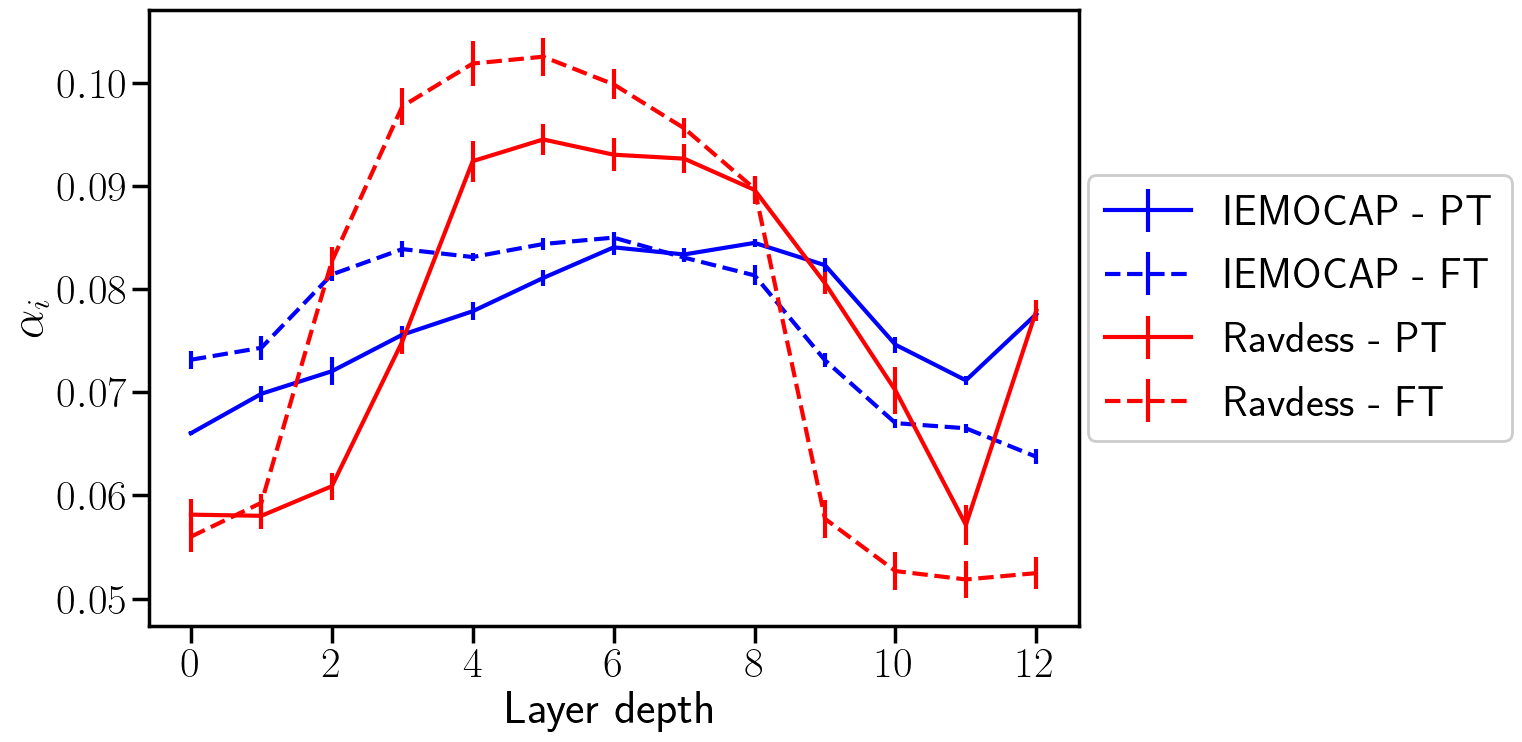

In [7]:
ravdess_ft = glob.glob('{}/w2v2LS960-alllayers/*/MainTask/DownstreamRavdess/RavdessModel/out'.format(RESULTS_PATH))
ravdess_pt = glob.glob('{}/w2v2PT-alllayers/*/MainTask/DownstreamRavdess/RavdessModel/out'.format(RESULTS_PATH))

iemocap_ft = glob.glob('{}/w2v2LS960-alllayers/*/MainTask/DownstreamIEMOCAP/IEMOCAPKFold/*/IEMOCAPModel/out'.format(RESULTS_PATH))
iemocap_pt = glob.glob('{}/w2v2PT-alllayers/*/MainTask/DownstreamIEMOCAP/IEMOCAPKFold/*/IEMOCAPModel/out'.format(RESULTS_PATH))

ravdess_ft_weights = [np.squeeze(joblib.load(model).core_model.model.get_layer('activations_wa').get_weights()[0]) for model in ravdess_ft]
ravdess_ft_weights = np.stack(ravdess_ft_weights)/np.expand_dims(np.sum(ravdess_ft_weights,axis=1),axis=-1)

ravdess_pt_weights = [np.squeeze(joblib.load(model).core_model.model.get_layer('activations_wa').get_weights()[0]) for model in ravdess_pt]
ravdess_pt_weights = np.stack(ravdess_pt_weights)/np.expand_dims(np.sum(ravdess_pt_weights,axis=1),axis=-1)

iemocap_ft_dict = {}
iemocap_pt_dict = {}

for w in iemocap_ft:
    fold = w.split('/')[-3]
    seed = w.split('/')[-7]
    weights = np.squeeze(joblib.load(w).core_model.model.get_layer('activations_wa').get_weights()[0])
    if seed in iemocap_ft_dict:
        iemocap_ft_dict[seed].append(weights)
    else:
        iemocap_ft_dict[seed] = [weights]
        
for w in iemocap_pt:
    fold = w.split('/')[-3]
    seed = w.split('/')[-7]
    weights = np.squeeze(joblib.load(w).core_model.model.get_layer('activations_wa').get_weights()[0])
    if seed in iemocap_pt_dict:
        iemocap_pt_dict[seed].append(weights)
    else:
        iemocap_pt_dict[seed] = [weights]
        
iemocap_ft_weights = [np.stack(v)/np.expand_dims(np.sum(v,axis=1),axis=-1) for k,v in iemocap_ft_dict.items()]
iemocap_pt_weights = [np.stack(v)/np.expand_dims(np.sum(v,axis=1),axis=-1) for k,v in iemocap_pt_dict.items()]

iemocap_pt_avgs = np.stack([np.mean(v,axis=0) for v in iemocap_pt_weights])
iemocap_ft_avgs = np.stack([np.mean(v,axis=0) for v in iemocap_ft_weights])

sns.set_context('poster',font_scale=1.4)
matplotlib.rcParams['text.usetex'] = True

plt.figure(figsize=(12,8))

plt.errorbar(np.arange(0,13),np.mean(iemocap_pt_avgs,axis=0),yerr=np.std(iemocap_pt_avgs,axis=0),fmt='-b',label='IEMOCAP - PT')
plt.errorbar(np.arange(0,13),np.mean(iemocap_ft_avgs,axis=0),yerr=np.std(iemocap_ft_avgs,axis=0),fmt='--b',label='IEMOCAP - FT')

plt.errorbar(np.arange(0,13),np.mean(ravdess_pt_weights,axis=0),yerr=np.std(ravdess_pt_weights,axis=0),fmt='-r',label='Ravdess - PT')
plt.errorbar(np.arange(0,13),np.mean(ravdess_ft_weights,axis=0),yerr=np.std(ravdess_ft_weights,axis=0),fmt='--r',label='Ravdess - FT')

plt.xlabel('Layer depth')
plt.ylabel(r'$\alpha_i$')
plt.legend(loc=(1.01,0.3), framealpha=1)

plt.savefig('fig-layerweights.pdf', bbox_inches='tight')
plt.show()